# In this example, we will rely on `pyjet` for jet clustering.

pyjet: https://github.com/scikit-hep/pyjet

In [2]:
import uproot
import pyjet
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import importlib
import time

from BranchClass import *

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm


## Define the class to fill particle information in to NumpyArray 

### User can use 
```
GenParticles = BrachGenParticles(file)
PID_all = GenParticles.PID
```
### to get all GenParticles PID array
### or
```
GenParticles = BrachGenParticles(file)
PID = GenParticles.PID_At(i)
```
### to get the GenParticles PID array in the ith event

## Define Function for Invariant Mass, Transverse Mass

### NOTE: the MT formula here is not compatible with MT in the collider physics, please modify this formula by yourself.

In [3]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)

# def MT(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
#     px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
#     e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
#     px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
#     e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
#     ET1, ET2  = np.sqrt(m1**2 + pt1**2), np.sqrt(m2**2 + pt2**2)
#     MT = np.sqrt( (ET1+ET2)**2 - (px1+px2)**2 - (py1+py2)**2 )
#     return MT

def MT(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2,missingET,missingETA,missingPHI):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    px_missing, py_missing = missingET*np.cos(missingPHI), missingET*np.sin(missingPHI)
    
    EllT = np.sqrt((px1+px2)**2 + (py1+py2)**2 +  M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2)**2 )

    MT = np.sqrt( (EllT+missingET)**2 - (px1+px2+px_missing)**2 - (py1+py2+py_missing)**2 )
    
    return MT
    
def E(pt,eta,phi,m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), np.sqrt(m**2+pt**2)*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    
    return e    

def THETA_Lab(pt,eta,phi,m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), np.sqrt(m**2+pt**2)*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    theta = np.arccos(np.dot(np.array([px, py, pz]),np.array([0,0,1]))/(np.linalg.norm([px, py, pz])*np.linalg.norm([0,0,1])))
    
    return theta

def THETA_CM(pt,eta,phi,m,Zp_pt,Zp_eta,Zp_phi,Zp_m):
    Zp_px, Zp_py, Zp_pz = Zp_pt*np.cos(Zp_phi), Zp_pt*np.sin(Zp_phi), np.sqrt(Zp_m**2+Zp_pt**2)*np.sinh(Zp_eta)
    Zp_e = np.sqrt(Zp_m**2 + Zp_px**2 + Zp_py**2 + Zp_pz**2)
    
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), np.sqrt(m**2+pt**2)*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    
    v = Zp_pz/Zp_e
    gamma = 1/np.sqrt(1-v**2)
    
    px_new, py_new, pz_new = px, py, gamma*(pz-v*e)
    e_new = gamma*(e-v*pz)
    
#     print(px_new, py_new, pz_new,e_new)
    
    if px_new != 0 and  py_new != 0 and pz_new != 0:
        theta = np.arccos(np.dot(np.array([px_new, py_new, pz_new]),np.array([0,0,1]))/(np.linalg.norm([px_new, py_new, pz_new])*np.linalg.norm([0,0,1])))
    else:
        theta = np.arccos(np.dot(np.array([px_new, py_new, pz_new]),np.array([0,0,1]))/(np.linalg.norm([0,0,1])))
    
    return theta


## Define Function for Finding two-same-sign W and Preselection

In [4]:




def Find_WW(GenParticle):
    print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    k = 0
    delta_eta_ww, delta_eta_ll = [], []
    M_WW, M_ll = [], []
    event_list = []
    WW_list, ll_list = [], []
    
    for N in range(GenParticle.length):

        WW_list_tmp, ll_list_tmp = [], []
        event_list_tmp = []
        event_list_tmp_tmp = []

        event_list_tmp.append([GenParticle.PT_At(N),  GenParticle.Eta_At(N), \
                               GenParticle.Phi_At(N), GenParticle.Mass_At(N), \
                               GenParticle.PID_At(N), GenParticle.Status_At(N),\
                               GenParticle.M1_At(N), GenParticle.M2_At(N),\
                               GenParticle.D1_At(N), GenParticle.D2_At(N)
                              ])

        event_list_tmp = np.array(event_list_tmp)
        
        WW_list_tmp = event_list_tmp[0][:,np.abs(event_list_tmp[0][4,:])==24]
        WW_list_tmp_tmp = []
        
        for i in range(len(WW_list_tmp[0])):
            ll_list_tmp_tmp = [] 
            if np.abs(GenParticle.PID_At(N)[int(WW_list_tmp[8][i])])!= 24 and np.abs(GenParticle.PID_At(N)[int(WW_list_tmp[9][i])]) != 24:
    #             print(i)
    #             print(WW_list_tmp)
    #             print("+++++++++")
    #             print(WW_list_tmp[:,i])
    #             print("+++++++++")
    #             print(GenParticle.PID_At(N)[int(WW_list_tmp[8][i])])
    #             print(GenParticle.PID_At(N)[int(WW_list_tmp[9][i])])
                WW_list_tmp_tmp.append(WW_list_tmp[:,i])
                doughter1 = event_list_tmp[0][:,int(WW_list_tmp[8][i])]
                doughter2 = event_list_tmp[0][:,int(WW_list_tmp[9][i])]
#                 print("k",k)
#                 print(int(WW_list_tmp[8][i]),int(WW_list_tmp[9][i]))
#                 print(doughter1[4],doughter1[6],int(WW_list_tmp[8][i]))
#                 print(doughter2[4],doughter2[6],int(WW_list_tmp[9][i]))
                if abs(doughter1[4]) == 11 or abs(doughter1[4]) == 13: 
                    ll_list_tmp_tmp.append(doughter1)
                    l1 = doughter1
#                     print(doughter1[4],doughter1[6])
                if abs(doughter2[4]) == 11 or abs(doughter2[4]) == 13: 
                    ll_list_tmp_tmp.append(doughter2)
                    l2 = doughter2
#                     print(doughter2[4],doughter2[6])
#                 if ll_list_tmp_tmp == []:
#                     print("k",k)
#                     print(int(WW_list_tmp[8][i]),int(WW_list_tmp[9][i]))
#                     print(doughter1[4],doughter1[6],int(WW_list_tmp[8][i]))
#                     print(doughter2[4],doughter2[6],int(WW_list_tmp[9][i]))
                if ll_list_tmp_tmp != []:
                    ll_list_tmp.append(ll_list_tmp_tmp)
    
        WW_list.append(np.array(WW_list_tmp_tmp).transpose())
        ll_list.append(np.array(ll_list_tmp).transpose())
    
        event_list_tmp = event_list_tmp[0][:,event_list_tmp[0][5,:]==1]

        event_list.append(event_list_tmp)

        W_1_pt = WW_list[N][:,0][0]
        W_1_eta = WW_list[N][:,0][1]
        W_1_phi = WW_list[N][:,0][2]
        W_1_m = WW_list[N][:,0][3]    
        
        W_2_pt = WW_list[N][:,1][0]
        W_2_eta = WW_list[N][:,1][1]
        W_2_phi = WW_list[N][:,1][2]
        W_2_m = WW_list[N][:,1][3]
        
        
        l_1_pt = ll_list[N][0,:][0][0]
        l_1_eta = ll_list[N][1,:][0][0]
        l_1_phi = ll_list[N][2,:][0][0]
        l_1_m = ll_list[N][3,:][0][0]
        
        l_2_pt = ll_list[N][0,:][0][1]
        l_2_eta = ll_list[N][1,:][0][1]
        l_2_phi = ll_list[N][2,:][0][1]
        l_2_m = ll_list[N][3,:][0][1]
            
#         print(l_1_eta,l_2_eta)
#         print(ll_list[N])
#         print(WW_list[0][:,1])
        
            
        delta_eta_ww.append(np.abs(W_1_eta - W_2_eta))
        M_WW.append(M(W_1_pt,W_1_eta,W_1_phi,W_1_m,W_2_pt,W_2_eta,W_2_phi,W_2_m))
        
        delta_eta_ll.append(np.abs(l_1_eta - l_2_eta))
        M_ll.append(M(l_1_pt,l_1_eta,l_1_phi,l_1_m,l_2_pt,l_2_eta,l_2_phi,l_2_m))
        
#         k += 1
#         if k == 79:
#             break
        
    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
    return delta_eta_ww, M_WW, WW_list, delta_eta_ll, M_ll, ll_list
    

def Preselection(Jet, Electron, Muon, MissingET):
    dijet_invariantmass, dilepton_invariantmass = [], []
    delta_jj, delta_ll = [], []
    energy_j = []
    TransverseMass = []
    survived_list = []
    for i in range(Jet.length):
        if len(Jet.PT_At(i)) < 2:
            continue

#         if Jet.PT_At(i)[0] < 440 or Jet.PT_At(i)[1] < 60:
#             continue

#         if np.abs(Jet.Eta_At(i)[0]- Jet.Eta_At(i)[1]) > 1.2:
#             continue
    
        if len(Electron.PT_At(i)) + len(Muon.PT_At(i)) < 2:
            continue
        
        if len(Electron.PT_At(i)) >= 1 and len(Muon.PT_At(i)) >= 1:
            dilepton_invariantmass.append(M(Electron.PT_At(i)[0],Electron.Eta_At(i)[0],Electron.Phi_At(i)[0],5E-4,
                                      Muon.PT_At(i)[0],Muon.Eta_At(i)[0],Muon.Phi_At(i)[0],1E-1))
            delta_ll.append(np.abs(Electron.Eta_At(i)[0]-Muon.Eta_At(i)[0]))
            TransverseMass.append(MT(Electron.PT_At(i)[0],Electron.Eta_At(i)[0],Electron.Phi_At(i)[0],5E-4,
                                      Muon.PT_At(i)[0],Muon.Eta_At(i)[0],Muon.Phi_At(i)[0],1E-1,
                                      MissingET.MET_At(i)[0],MissingET.Eta_At(i)[0],MissingET.Phi_At(i)[0]))
            
        elif len(Electron.PT_At(i)) >= 2:
            dilepton_invariantmass.append(M(Electron.PT_At(i)[0],Electron.Eta_At(i)[0],Electron.Phi_At(i)[0],5E-4,
                                      Electron.PT_At(i)[1],Electron.Eta_At(i)[1],Electron.Phi_At(i)[1],5E-4))
            delta_ll.append(np.abs(Electron.Eta_At(i)[0]-Electron.Eta_At(i)[1]))
            TransverseMass.append(MT(Electron.PT_At(i)[0],Electron.Eta_At(i)[0],Electron.Phi_At(i)[0],5E-4,
                                      Electron.PT_At(i)[1],Electron.Eta_At(i)[1],Electron.Phi_At(i)[1],5E-4,
                                      MissingET.MET_At(i)[0],MissingET.Eta_At(i)[0],MissingET.Phi_At(i)[0]))
        elif len(Muon.PT_At(i)) >= 2:
            dilepton_invariantmass.append(M(Muon.PT_At(i)[0],Muon.Eta_At(i)[0],Muon.Phi_At(i)[0],1E-1,
                                      Muon.PT_At(i)[1],Muon.Eta_At(i)[1],Muon.Phi_At(i)[1],1E-1))
            delta_ll.append(np.abs(Muon.Eta_At(i)[0]-Muon.Eta_At(i)[1]))
            TransverseMass.append(MT(Muon.PT_At(i)[0],Muon.Eta_At(i)[0],Muon.Phi_At(i)[0],1E-1,
                                      Muon.PT_At(i)[1],Muon.Eta_At(i)[1],Muon.Phi_At(i)[1],1E-1,
                                      MissingET.MET_At(i)[0],MissingET.Eta_At(i)[0],MissingET.Phi_At(i)[0]))
            
        dijet_invariantmass.append(M(Jet.PT_At(i)[0],Jet.Eta_At(i)[0],Jet.Phi_At(i)[0],Jet.Mass_At(i)[0],
                                      Jet.PT_At(i)[1],Jet.Eta_At(i)[1],Jet.Phi_At(i)[1],Jet.Mass_At(i)[1]))
        delta_jj.append(np.abs(Jet.Eta_At(i)[0]-Jet.Eta_At(i)[1]))
        
        energy_j.append(E(Jet.PT_At(i)[0],Jet.Eta_At(i)[0],Jet.Phi_At(i)[0],Jet.Mass_At(i)[0]))
        
        
        survived_list.append(i)

    print("There are {} events.".format(len(dijet_invariantmass)))
    
    return np.array(dijet_invariantmass), np.array(dilepton_invariantmass), np.array(delta_jj), np.array(delta_ll), np.array(TransverseMass), np.array(survived_list), np.array(energy_j)

## Import File

In [5]:
# process_path_herwig_angular = "/home/MC_Samples/Universality_DNN/Herwig_angular/ppwz_angular.root"
# #process_path_MEZJet = "/home/MC_Samples/Universality_DNN/Herwig_test_/LHC.root"
# process_path_pythia_default = "/home/MC_Samples/Universality_DNN/Pythia/ppzz_Simple.root"
# # process_path_pythia_2 = "/home/MC_Samples/Universality_DNN/Pythia/ppww_2.root"
# process_path_pythia_vincia = "/home/MC_Samples/Universality_DNN/Pythia_vincia/ppzz_vincia.root"
# process_path_pythia_dipole = "/home/MC_Samples/Universality_DNN/Pythia_dipole/ppzz_dipole.root"
# process_path_sherpa = "/home/MC_Samples/Universality_DNN/sherpa/sherpahep.root"

# process_path_herwig_angular_QCD = "/home/MC_Samples/Universality_DNN/Herwig_angular/ppjj_angular.root"
# process_path_pythia_default_QCD = "/home/MC_Samples/Universality_DNN/Pythia/ppjj.root"
# process_path_pythia_vincia_QCD = "/home/MC_Samples/Universality_DNN/Pythia_vincia/ppjj.root"
# process_path_pythia_dipole_QCD = "/home/MC_Samples/Universality_DNN/Pythia_dipole/ppjj.root"
# process_path_sherpa_QCD = "/home/MC_Samples/Universality_DNN/Sherpa_ppjj/sherpappjj.root"

process_path_herwig_angular = "./Data_root/ppwz_angular.root"
#process_path_MEZJet = "/home/MC_Samples/Universality_DNN/Herwig_test_/LHC.root"
process_path_pythia_default = "./Data_root/ppwz_pythia_default.root"
# process_path_pythia_2 = "/home/MC_Samples/Universality_DNN/Pythia/ppww_2.root"
process_path_pythia_vincia = "./Data_root/ppwz_pythia_vincia.root"
process_path_pythia_dipole = "./Data_root/ppwz_pythia_dipole.root"
process_path_sherpa = "./Data_root/ppwz_sherpa.root"

process_path_herwig_angular_QCD = "./Data_root/ppjj_angular.root"
process_path_pythia_default_QCD = "./Data_root/ppjj_pythia_default.root"
process_path_pythia_vincia_QCD = "./Data_root/ppjj_pythia_vincia.root"
process_path_pythia_dipole_QCD = "./Data_root/ppjj_pythia_dipole.root"
process_path_sherpa_QCD = "./Data_root/ppjj_sherpa.root"




try:
    herwig_angular = uproot.open(process_path_herwig_angular)["Delphes;1"]
    #MEZJet = uproot.open(process_path_MEZJet)["Delphes;1"]
    pythia_default = uproot.open(process_path_pythia_default)["Delphes;1"]
#     pythia_2 = uproot.open(process_path_pythia_2)["Delphes;1"]
    pythia_vincia = uproot.open(process_path_pythia_vincia)["Delphes;1"]
    pythia_dipole = uproot.open(process_path_pythia_dipole)["Delphes;1"]
    sherpa = uproot.open(process_path_sherpa)["Delphes;1"]
    
    herwig_angular_QCD = uproot.open(process_path_herwig_angular_QCD)["Delphes;1"]
    pythia_default_QCD = uproot.open(process_path_pythia_default_QCD)["Delphes;1"]
    pythia_vincia_QCD = uproot.open(process_path_pythia_vincia_QCD)["Delphes;1"]
    pythia_dipole_QCD = uproot.open(process_path_pythia_dipole_QCD)["Delphes;1"]
    sherpa_QCD = uproot.open(process_path_sherpa_QCD)["Delphes;1"]
    
    
#     process_list = [ppwz, pythia_1, pythia_2]
    
    print("All Files are loaded!")
    
except:
    print("Please Check Input Files")


All Files are loaded!


#  Print the Branch in the Delphes

In [5]:
# file_3_5.show()

In [6]:
def Event_List(GenParticle):
    print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    
    k = 0
    event_list = []
    
    for N in range(GenParticle.length):
        
        event_list_tmp = []
        event_list_tmp_tmp = []


        event_list_tmp.append([GenParticle.PT_At(N),  GenParticle.Eta_At(N), \
                               GenParticle.Phi_At(N), GenParticle.Mass_At(N), \
                               GenParticle.PID_At(N), GenParticle.Status_At(N)
                              ])

        event_list_tmp = np.array(event_list_tmp)

        
        
#         if np.abs(event_list_tmp[0][4,:]) == 12:
#             print(np.abs(event_list_tmp[0][4,:]))
#         aaaa = event_list_tmp[0][:,np.abs(event_list_tmp[0][4,:])!=12]
#         aaaa = aaa[0]
#         print(len(aaaa[0]))
#         print(aaaa[:,np.abs(aaaa[5,:])==1])
#         event_list_tmp = event_list_tmp[0][:,np.abs(event_list_tmp[0][4,:])!=12]
#         event_list_tmp = event_list_tmp[0][:,np.abs(event_list_tmp[0][4,:])!=14]
#         event_list_tmp = event_list_tmp[0][:,np.abs(event_list_tmp[0][4,:])!=16]
    
        event_list_tmp = event_list_tmp[0][:,event_list_tmp[0][5,:]==1]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=12]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=14]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=16]
        
        event_list.append(event_list_tmp)
        
#         k += 1
#         if k == 1:
#             break

    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
    
    return event_list

## Load event via class

In [ ]:
# importlib.reload(BranchClass)

GenParticle_herwig_angular = BrachGenParticles(herwig_angular)
# #GenParticle_MEZJ = BrachGenParticles(MEZJet)
GenParticle_pythia_default = BrachGenParticles(pythia_default)
# GenParticle_pythia_2 = BrachGenParticles(pythia_2)
GenParticle_pythia_vincia = BrachGenParticles(pythia_vincia)
GenParticle_pythia_dipole = BrachGenParticles(pythia_dipole)
GenParticle_sherpa = BrachGenParticles(sherpa)


Event_List_herwig_angular = Event_List(GenParticle_herwig_angular)
Event_List_pythia_default = Event_List(GenParticle_pythia_default)
# Event_List_pythia_2 = Event_List(GenParticle_pythia_2)
Event_List_pythia_vincia = Event_List(GenParticle_pythia_vincia)
Event_List_pythia_dipole = Event_List(GenParticle_pythia_dipole)
Event_List_sherpa = Event_List(GenParticle_sherpa)
#Event_List_MEZJet = Event_List(GenParticle_MEZJet)


GenParticle_herwig_angular_QCD = BrachGenParticles(herwig_angular_QCD)
Event_List_herwig_angular_QCD = Event_List(GenParticle_herwig_angular_QCD)
GenParticle_pythia_default_QCD = BrachGenParticles(pythia_default_QCD)
Event_List_pythia_default_QCD = Event_List(GenParticle_pythia_default_QCD)
GenParticle_pythia_vincia_QCD = BrachGenParticles(pythia_vincia_QCD)
Event_List_pythia_vincia_QCD = Event_List(GenParticle_pythia_vincia_QCD)
GenParticle_pythia_dipole_QCD = BrachGenParticles(pythia_dipole_QCD)
Event_List_pythia_dipole_QCD = Event_List(GenParticle_pythia_dipole_QCD)
GenParticle_sherpa_QCD = BrachGenParticles(sherpa_QCD)
Event_List_sherpa_QCD = Event_List(GenParticle_sherpa_QCD)



Tue Oct 27 12:37:52 2020
Time Cost : 0.2459 min
Tue Oct 27 12:38:06 2020
Time Cost : 0.2728 min
Tue Oct 27 12:38:23 2020
Time Cost : 0.2334 min
Tue Oct 27 12:38:37 2020
Time Cost : 0.2738 min
Tue Oct 27 12:38:53 2020
Time Cost : 0.2243 min


In [ ]:
# Event_List_ppwz[0][:,np.abs(Event_List_ppwz[0][4,:])==12]

In [ ]:
print(len(GenParticle_herwig_angular_QCD.Status))
# print(len(Event_List_MEZJet))

# Let's do jet clustering!!
### We use ` np.core.records.fromarrays` to assign the name of kinematic variables and PID
### In `pyjet`, the data type are only 
`
np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')])
`
### or (cluster(..., ep=True))
`
np.dtype([('E', 'f8'), ('px', 'f8'), ('py', 'f8'), ('pz', 'f8')])  
`
### In this example, we use `(pt, eta, phi and mass)`.
### After assigning the name for our each event list, the `pyjet.cluster` and `inclusive_jets` will help us do jet clustering.
`
sequence_cluster = pyjet.cluster(to_cluster, R = 0.4,p = -1)
jets_cluster = sequence_cluster.inclusive_jets(pt_min)
`
#### Variable: `R` is the cone size of the jet.
#### Variable: `p` is the jet clustering algorithm. `-1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt`
#### Variable: `pt_min` is the minimum jet's pt.



In [ ]:
event_list = [Event_List_herwig_angular,Event_List_pythia_default,Event_List_pythia_vincia,Event_List_pythia_dipole,Event_List_sherpa,
              Event_List_herwig_angular_QCD,Event_List_pythia_default_QCD,Event_List_pythia_vincia_QCD,Event_List_pythia_dipole_QCD,Event_List_sherpa_QCD]
event_list_clustered = [[],[],[],[],[],[],[],[],[],[]]


# event_list = [Event_List_herwig_angular,Event_List_pythia_default,
#               Event_List_herwig_angular_QCD,Event_List_pythia_default_QCD]
# event_list_clustered = [[],[],[],[]]

# event_list = [Event_List_herwig_angular_QCD,Event_List_sherpa_QCD]
# event_list_clustered = [[],[]]
for i, element in enumerate(event_list):
    print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
    ticks_1 = time.time()
    for j in range(len(element)):
        
#         print(len(element[j]))
        to_cluster = np.core.records.fromarrays(element[j], 
                                                 names="pT, eta, phi, mass, PID, Status",
                                                 formats = "f8, f8, f8, f8, f8, f8")
        pt_min = 20
        sequence_cluster = pyjet.cluster(to_cluster, R = 0.8, p = -1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
        jets_cluster = sequence_cluster.inclusive_jets(pt_min)
        event_list_clustered[i].append(jets_cluster)
#         print("j",j)
        if j == 5000:
            break
    
    ticks_2 = time.time()
    totaltime =  ticks_2 - ticks_1
    print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

In [29]:
len(event_list_clustered[0])

5001

# Print jets in the Nth event

In [30]:
# index = 0
# N = 0

# for i, jets in enumerate(event_list_clustered[index][N]):
#     print("{}".format("No." +str(i)+" Jet's Information"))
#     print(jets)
#     print("-------------------------------------------------------------------------")
#     print("{:^19} {:^20} ".format("Constituent's PID","Constituent's Four Momentum"))
#     print("-------------------------------------------------------------------------")
    
#     for constituent in jets: # get constituent in each "jet_element"
#         print("{:^19} {} ".format(int(constituent.PID), constituent))
#     print("-------------------------------------------------------------------------")

# Print the Truth Record in an Event

In [31]:
# # GenParticle = GenParticle_ppwz
# GenParticle = GenParticle_sherpa_QCD



# print("There are {} information in this event.".format(len(GenParticle.Status[0])))
# print("GenParticle Information")
# print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

# index = 0 ## which event you want to print out
# k = 0
# for j in range(len(GenParticle.Status_At(index))):
    
# #     if GenParticle.Status_At(index)[j] == 1: ##Selet the Stable Final State Particles
# #         if np.abs(GenParticle.PID_At(index)[j]) == 12 or np.abs(GenParticle.PID_At(index)[j]) == 14:

# #     if np.abs(GenParticle.PID_At(index)[GenParticle.M1_At(index)[j]]) == 24 or np.abs(GenParticle.PID_At(index)[GenParticle.M2_At(index)[j]]) == 24:
# #     if np.abs(GenParticle.PID_At(index)[GenParticle.M1_At(index)[j]]) == 23 or np.abs(GenParticle.PID_At(index)[GenParticle.M2_At(index)[j]]) == 23:


#         print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.2}{:^8.2}{:^8.2}{:^8.2}".format( \
#         j, GenParticle.Status_At(index)[j],  GenParticle.PID_At(index)[j], GenParticle.M1_At(index)[j], GenParticle.M2_At(index)[j],
#          GenParticle.D1_At(index)[j], GenParticle.D2_At(index)[j],  GenParticle.PT_At(index)[j],  GenParticle.Eta_At(index)[j], GenParticle.Phi_At(index)[j], GenParticle.Mass_At(index)[j]))

# #             k +=1
# # print(k)

# mono-Jet Events' Selection From Truth Record
### We want to compare the inavriant mass distribution between two reconstructed jets and two dark quarks.
### We need select the events with # of jet >=1.

In [32]:
M_J = [[],[],[],[],[],[],[],[],[],[]]
PT_J = [[],[],[],[],[],[],[],[],[],[]]
event_sele = [[],[],[],[],[],[],[],[],[],[]]
angular_1 = [[],[],[],[],[],[],[],[],[],[]]
angular_2 = [[],[],[],[],[],[],[],[],[],[]]

# M_J = [[],[],[],[]]
# PT_J = [[],[],[],[]]
# event_sele = [[],[],[],[]]
# angular_1 = [[],[],[],[]]
# angular_2 = [[],[],[],[]]


# M_J = [[],[]]
# PT_J = [[],[]]
# event_sele = [[],[]]
# angular_1 = [[],[]]
# angular_2 = [[],[]]

for i, element in enumerate(event_list_clustered):
    for N in range(len(element)):

        if len(element[N]) >= 1: # at least two jets in this event.
            jet_1 = element[N][0] #leading jet's information
#             jet_2 = element[N][1] #subleading jet's information

            M_J[i].append(jet_1.mass)
            PT_J[i].append(jet_1.pt)
            event_sele[i].append(N)
#             theta_1 = THETA(jet_1.pt,jet_1.eta,jet_1.phi,jet_1.mass)
#             angular_1[i].append(theta_1)
#             theta_2 = THETA(jet_2.pt,jet_2.eta,jet_2.phi,jet_2.mass)
#             angular_2[i].append(theta_2)
            
    print("There are {} events passed this mono-jet selection.".format(len(M_J[i])))
    

There are 5001 events passed this mono-jet selection.
There are 5001 events passed this mono-jet selection.
There are 5001 events passed this mono-jet selection.
There are 5001 events passed this mono-jet selection.
There are 5001 events passed this mono-jet selection.
There are 5001 events passed this mono-jet selection.
There are 5001 events passed this mono-jet selection.
There are 5001 events passed this mono-jet selection.
There are 5001 events passed this mono-jet selection.
There are 5001 events passed this mono-jet selection.


## Example 1: Plot in differential number of event

In [33]:
def HIST(process, length, title, colors, linestyle,xpo=1,ypo=1):
    hist, bins = np.histogram(process, bins=length)
    plt.step(bins[:-1], hist.astype(np.float32) / hist.sum(), linestyle ,color= colors ,where='mid',linewidth=5, alpha=0.7, label=title[i])
#     plt.legend(bbox_to_anchor=(xpo, ypo),ncol=1,fontsize=30, edgecolor = "w",fancybox=False, framealpha=0)
    plt.legend(loc="best",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0)
    
title = ["Herwig Angular", "Pythia default", "Pythia vincia", "Pythia dipole", "Sherpa", 
         "Herwig Angular QCD", "Pythia default QCD", "Pythia vincia QCD", "Pythia dipole QCD","Sherpa QCD"]
colors = ["green","red","darkred","blue","magenta",
          "cyan","orange","darkred","darkblue","darkgreen"]
linestyle = ["-","-.","--",":","X",
             "D","s","^","H","h","*"]
# colors = ["green","red","darkred","blue","magenta"]
# linestyle = ["-","-.","--",":","X"]

    
# title = ["Herwig Angular", "Pythia default","Herwig Angular QCD", "Pythia default QCD"]
# colors = ["green","red","darkred","blue"]
# linestyle = ["-","-.","--",":"]


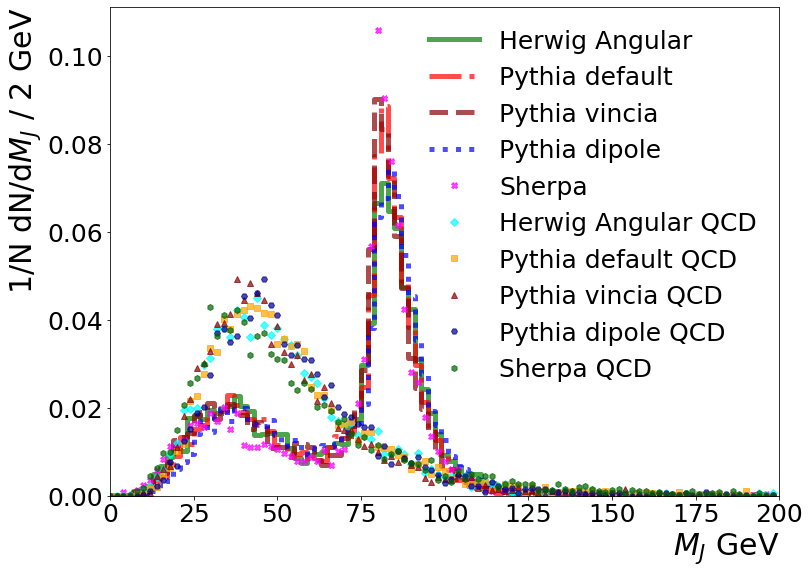

In [34]:
M_j = M_J

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(M_j):
    length = np.linspace(0,200,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,200))
    plt.xlabel("$M_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$M_{J}$ / 2 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()    
    

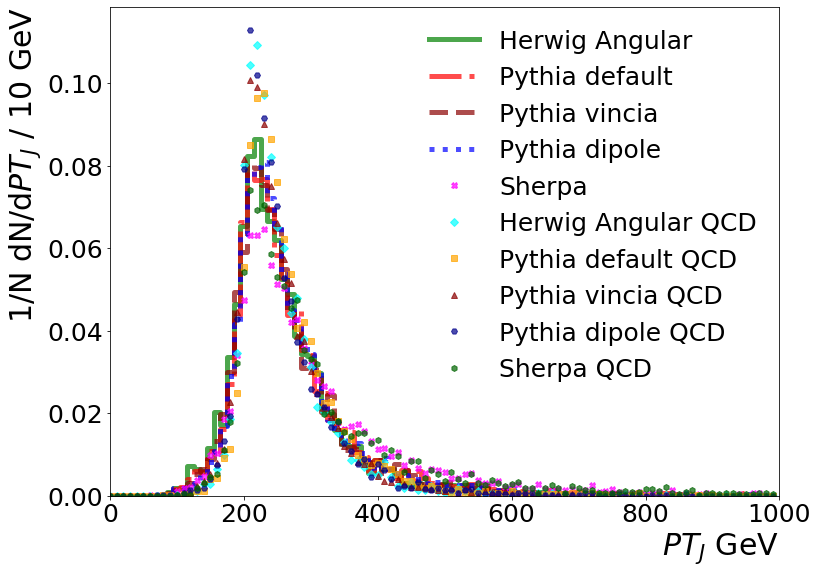

In [35]:

PT_j = PT_J

fig, ax = plt.subplots(1,1, figsize=(12,9))
for i, process in enumerate(PT_j):
    length = np.linspace(0,1000,101)
    HIST(process, length, title,colors[i],linestyle[i])
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    plt.xlim((0,1000))
    plt.xlabel("$PT_{J}$ GeV", fontsize=30,horizontalalignment='right',x=1) 

    
plt.ylim((0.))
plt.ylabel("1/N dN/d$PT_{J}$ / 10 GeV", fontsize=30, horizontalalignment='right',y=1)
# plt.savefig("./Plots/m_ww_parton.png", transparent=True, bbox_inches='tight')  #save figure as png
plt.show()    